In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle

/Users/michal/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('./fer2013/fer2013.csv')
df.sample(5)

,emotion,pixels,Usage
9933,3,214 214 215 214 221 142 37 64 88 30 57 235 255...,Training
29090,5,255 254 255 212 184 185 174 166 158 216 220 22...,PublicTest
20036,6,42 43 51 49 50 57 73 104 142 159 164 172 190 1...,Training
20563,4,59 61 44 51 50 55 63 76 100 114 154 209 204 21...,Training
26095,4,27 37 44 30 63 50 7 11 25 46 84 124 158 167 17...,Training


In [3]:
def error_rate(pred, target):
    return np.mean(pred!=target)

In [4]:
def classification_rate(p, t):
    return np.mean(p == t)

In [5]:
def ohe(labels):
    ohe_lab = np.zeros((labels.shape[0], len(set(labels))))
    for i in range(len(labels)):
        ohe_lab[i, labels[i]] = 1
    return ohe_lab     

In [6]:
def rearrange(X):
    return (X.transpose(0, 2, 3, 1) / 255).astype(np.float32)

In [7]:
Y_all = df['emotion'].astype(int)
X_all = []
for i in df['pixels']:
    X_all.append([int(p) for p in i.split()]) #acts like getData()
X_all, Y_all = np.array(X_all), np.array(Y_all)
X_all = np.reshape(X_all, (X_all.shape[0], 1, 48, 48)) #acts like getImageData()

In [8]:
X = rearrange(X_all)
Y = ohe(Y_all)

In [9]:
print(X.shape)
print(type(X))
print(Y.shape)
print(type(Y))

(35887, 48, 48, 1)
<class 'numpy.ndarray'>
(35887, 7)
<class 'numpy.ndarray'>


In [10]:
def conv_pool(X, W, b):
    conv_out = tf.nn.conv2d(X, W, strides=[1,1,1,1], padding='SAME')
    conv_out = tf.nn.bias_add(conv_out, b)
    conv_act = tf.nn.relu(conv_out)
    pool_out = tf.nn.max_pool(conv_act, [1,2,2,1], [1,2,2,1], padding='SAME')
    return pool_out

In [11]:
max_iter = 50
print_period = 20
lr = 1e-5
reg = 1e-2

In [12]:
X_train = X[:-1000]
Y_train = Y[:-1000]
X_test = X[-1000:]
Y_test = Y[-1000:]

In [13]:
N = X_train.shape[0]
batch_size = 100
num_batches = N//batch_size

In [14]:
# input filter size
# filter_size = (3, 3)
# filter_weighs -> (width, height, col_chan, feat_maps)
W1_cp_init = np.random.randn(3, 3, 1, 16)
b1_cp_init = np.zeros(16)
W2_cp_init = np.random.randn(3, 3, 16, 32)
b2_cp_init = np.zeros(32)
W3_cp_init = np.random.randn(3, 3, 32, 64)
b3_cp_init = np.zeros(64)

In [15]:
# image size = 6x6, num filters = 64
dense_input = 6*6*64 
dense_input

2304

In [16]:
# hidden layer1 nodes
M1 = 2000
# hidden layer2 nodes
M2 = 1000
# hidden layer3 nodes
M3 = 500
# output nodes
K = 7
# starting wieghts
W1_init = np.random.randn(dense_input, M1) / np.sqrt(dense_input+ M1)
b1_init = np.zeros(M1)
W2_init = np.random.randn(M1, M2) / np.sqrt(M1+M2)
b2_init = np.zeros(M2)
W3_init = np.random.randn(M2, M3) / np.sqrt(M2+M3)
b3_init = np.zeros(M3)
W4_init = np.random.randn(M3, K) / np.sqrt(M3+K)
b4_init = np.zeros(K)

In [17]:
# get TF variables for the inputs, X and targets T
ftX = tf.placeholder(tf.float32, shape=(None, 48, 48, 1), name='X')
ftT = tf.placeholder(tf.float32, shape=(None, K), name='T')

In [18]:
#get TF variables wieghts and biases - CONV
W1_cp = tf.Variable(W1_cp_init.astype(np.float32))
b1_cp = tf.Variable(b1_cp_init.astype(np.float32))
W2_cp = tf.Variable(W2_cp_init.astype(np.float32))
b2_cp = tf.Variable(b2_cp_init.astype(np.float32))
W3_cp = tf.Variable(W3_cp_init.astype(np.float32))
b3_cp = tf.Variable(b3_cp_init.astype(np.float32))

In [19]:
# get TF variables wieghts and biases _ DENSE
W1 = tf.Variable(W1_init.astype(np.float32))
b1 = tf.Variable(b1_init.astype(np.float32))
W2 = tf.Variable(W2_init.astype(np.float32))
b2 = tf.Variable(b2_init.astype(np.float32))
W3 = tf.Variable(W3_init.astype(np.float32))
b3 = tf.Variable(b3_init.astype(np.float32))
W4 = tf.Variable(W4_init.astype(np.float32))
b4 = tf.Variable(b4_init.astype(np.float32))

In [20]:
Z1 = conv_pool(ftX, W1_cp, b1_cp)
Z2 = conv_pool(Z1, W2_cp, b2_cp)
Z3 = conv_pool(Z2, W3_cp, b3_cp)

Z3_shape = Z3.get_shape().as_list()
Z3_r = tf.reshape(Z3, [-1, np.prod(Z3_shape[1:])])

Z4 = tf.nn.relu(tf.matmul(Z3_r, W1)+b1)
Z5 = tf.nn.relu(tf.matmul(Z4, W2)+b2)
Z6 = tf.nn.relu(tf.matmul(Z5, W3)+b3)
Yish = tf.matmul(Z6, W4)+b4

In [21]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    labels=ftT, logits=Yish)) #+ rcost

In [22]:
pred = tf.argmax(Yish, 1)

In [23]:
train_op = tf.train.RMSPropOptimizer(lr, decay=0.999, momentum=0.99).minimize(cost)

In [24]:
LL = []
error = []
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(max_iter):
        X_train, Y_train = shuffle(X_train, Y_train)
        for j in range(num_batches):
            X_batch = X_train[(j*batch_size):(j*batch_size+batch_size)]
            Y_batch = Y_train[(j*batch_size):(j*batch_size+batch_size)]
        
            sess.run(train_op, feed_dict = {ftX: X_batch, ftT: Y_batch})
            if j % print_period == 0:
                cost_val = sess.run(cost, feed_dict={ftX: X_test, ftT: Y_test})
                pred_val = sess.run(pred, feed_dict={ftX: X_test})
                err = error_rate(pred_val, Y_test.argmax(axis = 1))
                print(i,j,cost_val,err)
                LL.append(cost_val)
                error.append(err)

0 0 17.463093 0.861
0 20 22.00947 0.842
0 40 15.814519 0.872
0 60 16.070288 0.82
0 80 7.1700826 0.852
0 100 3.5323472 0.777
0 120 3.5747807 0.841
0 140 2.8362749 0.822
0 160 2.5870392 0.805
0 180 2.2801516 0.779
0 200 2.2092738 0.782
0 220 1.9624463 0.754
0 240 1.9067222 0.794
0 260 1.8844478 0.8
0 280 1.8785956 0.746
0 300 1.9470762 0.74
0 320 1.8797272 0.741
0 340 1.8877678 0.765
1 0 1.7987187 0.733
1 20 1.8890738 0.769
1 40 1.8678505 0.742
1 60 1.8195307 0.807
1 80 1.8334434 0.738
1 100 1.8282559 0.774
1 120 1.789154 0.737
1 140 1.7748216 0.735
1 160 1.750191 0.715
1 180 1.7535325 0.698
1 200 1.7811561 0.719
1 220 1.7714887 0.722
1 240 1.759686 0.733
1 260 1.7504829 0.719
1 280 1.775348 0.727
1 300 1.7904379 0.735
1 320 1.7803471 0.738
1 340 1.7276441 0.689
2 0 1.7488157 0.714
2 20 1.740411 0.718
2 40 1.7332032 0.69
2 60 1.7411811 0.705
2 80 1.7257793 0.688
2 100 1.7139702 0.675
2 120 1.7120223 0.671
2 140 1.7104443 0.697
2 160 1.7035801 0.69
2 180 1.6868097 0.672
2 200 1.6910743 0.

20 300 1.4554563 0.558
20 320 1.4372382 0.544
20 340 1.5116122 0.596
21 0 1.4629788 0.574
21 20 1.5052031 0.562
21 40 1.4506711 0.557
21 60 1.4704697 0.568
21 80 1.4797051 0.564
21 100 1.4659 0.557
21 120 1.4456505 0.571
21 140 1.4371648 0.549
21 160 1.4381982 0.552
21 180 1.46631 0.572
21 200 1.4285413 0.538
21 220 1.4622151 0.548
21 240 1.43805 0.565
21 260 1.4397341 0.559
21 280 1.4573622 0.56
21 300 1.4730036 0.569
21 320 1.4269385 0.558
21 340 1.4583204 0.598
22 0 1.4692246 0.59
22 20 1.4637784 0.584
22 40 1.4642843 0.544
22 60 1.4420419 0.558
22 80 1.4800594 0.587
22 100 1.4332374 0.543
22 120 1.445489 0.55
22 140 1.4282604 0.541
22 160 1.4427222 0.557
22 180 1.4315523 0.547
22 200 1.4143285 0.542
22 220 1.4349436 0.538
22 240 1.4425172 0.552
22 260 1.4848936 0.562
22 280 1.4381038 0.553
22 300 1.416792 0.546
22 320 1.42052 0.534
22 340 1.4423045 0.581
23 0 1.43998 0.546
23 20 1.5204214 0.581
23 40 1.4695439 0.54
23 60 1.441089 0.555
23 80 1.4431493 0.543
23 100 1.4428194 0.563
2

41 60 2.311685 0.537
41 80 2.3952005 0.517
41 100 2.2733717 0.539
41 120 2.4462419 0.529
41 140 2.1835227 0.526
41 160 2.254901 0.518
41 180 2.2942195 0.518
41 200 2.2501109 0.519
41 220 2.3599112 0.538
41 240 2.2830951 0.529
41 260 2.2025588 0.553
41 280 2.268624 0.527
41 300 2.3892477 0.539
41 320 2.145888 0.532
41 340 2.11433 0.514
42 0 2.072643 0.524
42 20 2.091875 0.536
42 40 2.2508044 0.517
42 60 2.3252642 0.548
42 80 2.4340024 0.532
42 100 2.3568692 0.527
42 120 2.320799 0.528
42 140 2.409522 0.544
42 160 2.3772597 0.535
42 180 2.5615757 0.537
42 200 2.4547312 0.552
42 220 2.4719746 0.544
42 240 2.3568068 0.531
42 260 2.4348066 0.545
42 280 2.3304296 0.554
42 300 2.3965497 0.548
42 320 2.452747 0.53
42 340 2.3149285 0.524
43 0 2.352888 0.523
43 20 2.5225098 0.542
43 40 2.5135717 0.534
43 60 2.4795544 0.532
43 80 2.563449 0.531
43 100 2.5787828 0.541
43 120 2.5580297 0.536
43 140 2.6922688 0.534
43 160 2.6719444 0.533
43 180 2.6636615 0.531
43 200 2.6249547 0.518
43 220 2.579852 

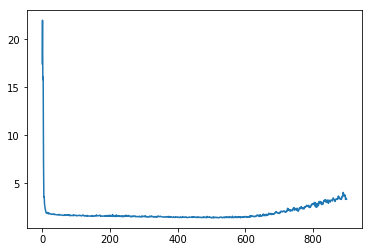

In [25]:
plt.plot(LL)
plt.show()

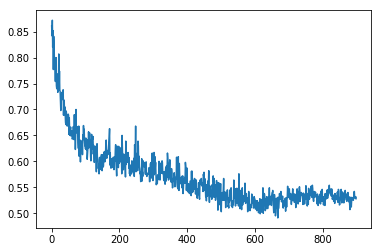

In [26]:
plt.plot(error)
plt.show()